- 참고 사이트

https://haystar.tistory.com/72

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
import matplotlib.cm as cm

In [ ]:
from keras import backend as K

# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [ ]:
# Load the best model
model = load_model("/content/drive/MyDrive/eardrum/model/crop_model.h5",
                        custom_objects={'precision': precision,
                                          'recall': recall,
                                          'f1': f1})

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

In [ ]:
data_path = '/content/drive/MyDrive/eardrum2/crop_data/train/Abnormal/'
#data_path = '/content/drive/MyDrive/eardrum2/last_test_png/'
image_path = data_path+'otitexterna_27.png'  # 이미지 파일 경로

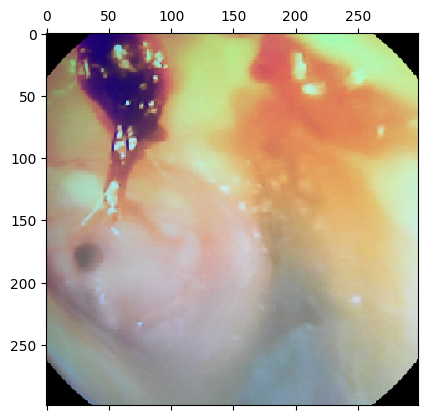

In [ ]:
img = image.load_img(image_path, target_size = (299,299))
plt.matshow(img)

In [ ]:
from tensorflow.keras.applications import xception

In [ ]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=xception.preprocess_input(x)

In [ ]:
# 모델의 층과 이름 출력
for layer in model.layers[-10:]:
    print(layer.name)


add_23
block14_sepconv1
block14_sepconv1_bn
block14_sepconv1_act
block14_sepconv2
block14_sepconv2_bn
block14_sepconv2_act
global_average_pooling2d_1
dense_2
dense_3


In [ ]:
last_conv_layer = model.get_layer("block14_sepconv2_act")

In [ ]:
model_1= keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("global_average_pooling2d_1")(input_2)
x_2 = model.get_layer("dense_2")(x_2)
x_2 = model.get_layer("dense_3")(x_2)
model_2=keras.Model(input_2,x_2)

In [ ]:
with tf.GradientTape() as tape:
    output_1 = model_1(x)
    tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]

grads = tape.gradient(output_1, output_1) #그레디언트 계산
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용


In [ ]:
output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]

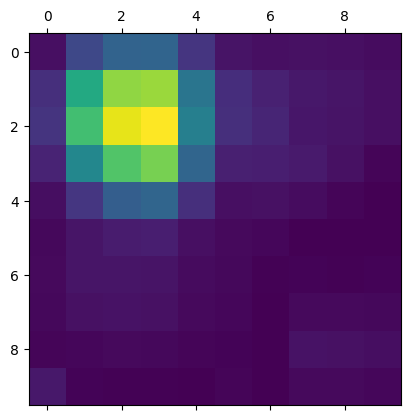

In [ ]:
heatmap=np.mean(output_1, axis=-1)
heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화
plt.matshow(heatmap)

<ipython-input-124-4fb213d828ae>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet") #jet 컬러맵으로 표시


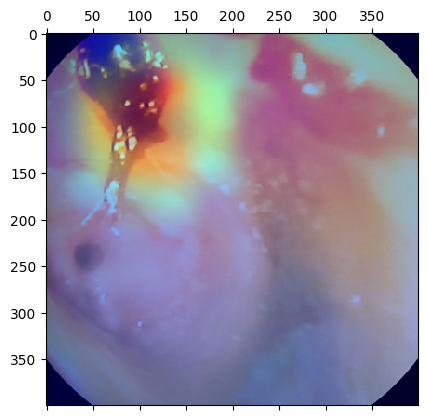

In [ ]:
img =image.load_img(image_path) #입력 영상을 다시 받음

img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]

color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img= color_heatmap*0.4+img #덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

# 원본이미지를 함수 내에서 크롭시켜서 히트맵 출력하기

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import xception
from tensorflow.keras.applications.xception import preprocess_input
# tf.keras.applications.xception.preprocess_input

In [ ]:
from tensorflow import keras
import matplotlib.cm as cm

In [ ]:
data_path = '/content/drive/MyDrive/eardrum2/data_2_kfold/train/Abnormal/'
# data_path = '/content/drive/MyDrive/eardrum2/last_test_png/'
image_path = data_path+'otitexterna_27.png'  # 이미지 파일 경로

In [ ]:
from PIL import Image
import io

In [ ]:
original_image = Image.open(image_path)
cropped = tf.image.central_crop(original_image, central_fraction=0.8)
encoded_image = tf.image.encode_png(cropped)

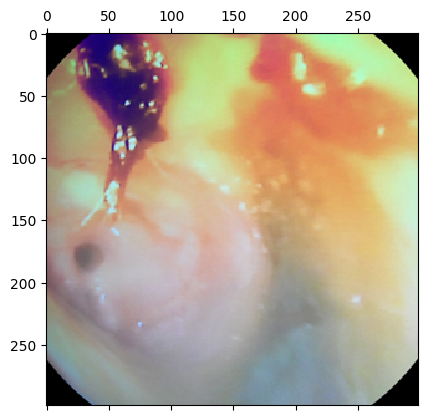

In [ ]:
# EagerTensor를 numpy 배열로 변환
encoded_image_np = encoded_image.numpy()
cropped_img_410 = Image.open(io.BytesIO(encoded_image_np))
cropped_img = cropped_img_410.resize((299, 299))

# 이미지 시각화
plt.matshow(cropped_img)
plt.show()

In [ ]:
x=image.img_to_array(cropped_img)
x=np.expand_dims(x,axis=0)
# 이미지 데이터를 전처리하기 전에 복사하여 새로운 배열을 생성
x = x.copy()
x = preprocess_input(x)

In [ ]:
last_conv_layer = model.get_layer("block14_sepconv2_act")
model_1= keras.Model(model.inputs, last_conv_layer.output)

input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("global_average_pooling2d_1")(input_2)
x_2 = model.get_layer("dense_2")(x_2)
x_2 = model.get_layer("dense_3")(x_2)
model_2=keras.Model(input_2,x_2)

In [ ]:
with tf.GradientTape() as tape:
    output_1 = model_1(x)
    tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]

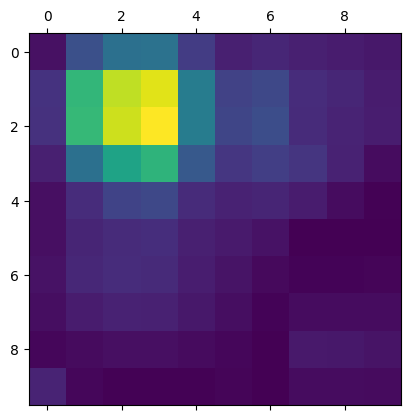

In [ ]:
grads = tape.gradient(output_1, output_1) #그레디언트 계산
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용

output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]

heatmap=np.mean(output_1, axis=-1)
heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화
plt.matshow(heatmap) # -> 히트맵 출력

<ipython-input-65-e91a56eecc09>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet") #jet 컬러맵으로 표시


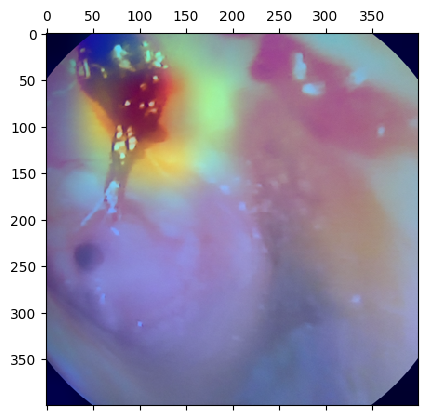

In [ ]:
img =image.load_img(image_path)
# 이미지를 배열로 변환
img = image.img_to_array(img)

# 이미지를 텐서로 변환
img_tensor = tf.convert_to_tensor(img)

# 중앙 부분을 80%로 크롭
cropped = tf.image.central_crop(img_tensor, central_fraction=0.8)

# 크롭된 이미지 시각화
cropped_img = cropped.numpy().astype(np.uint8)

heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]

color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((cropped_img.shape[1], cropped_img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img= color_heatmap*0.4+cropped_img #덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

# 원본 이미지 자동 크롭해서 히트맵과 오버레이 이미지 출력시키는 함수

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

def show_heatmap(image_path, model):
    original_image = Image.open(image_path)
    cropped = tf.image.central_crop(original_image, central_fraction=0.8)
    encoded_image = tf.image.encode_png(cropped)

    # EagerTensor를 numpy 배열로 변환
    encoded_image_np = encoded_image.numpy()
    cropped_img_410 = Image.open(io.BytesIO(encoded_image_np))
    cropped_img = cropped_img_410.resize((299, 299))

    # tf.keras.preprocessing.image
    x = tf.keras.preprocessing.image.img_to_array(cropped_img)
    x = np.expand_dims(x, axis=0)
    # 이미지 데이터를 전처리하기 전에 복사하여 새로운 배열을 생성
    x = x.copy()
    x = tf.keras.applications.xception.preprocess_input(x)

    last_conv_layer = model.get_layer("block14_sepconv2_act")
    model_1 = keras.Model(model.inputs, last_conv_layer.output)

    input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
    x_2 = model.get_layer("global_average_pooling2d_1")(input_2)
    x_2 = model.get_layer("dense_2")(x_2)
    x_2 = model.get_layer("dense_3")(x_2)
    model_2 = keras.Model(input_2, x_2)

    with tf.GradientTape() as tape:
        output_1 = model_1(x)
        tape.watch(output_1)  # 마지막 층으로 미분하기 위한 준비
        preds = model_2(output_1)
        class_id = tf.argmax(preds[0])
        output_2 = preds[:, class_id]

    grads = tape.gradient(output_1, output_1)  # 그레디언트 계산
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # 식5 적용

    output_1 = output_1.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        output_1[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(output_1, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # 정규화

    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = tf.convert_to_tensor(img)

    cropped = tf.image.central_crop(img_tensor, central_fraction=0.8)
    cropped_img = cropped.numpy().astype(np.uint8)

    heatmap = np.uint8(255 * heatmap)  # [0,255]로 변환

    jet = matplotlib.colormaps.get_cmap("jet")  # jet 컬러맵으로 표시
    color = jet(np.arange(256))[:, :3]
    color_heatmap = color[heatmap]

    color_heatmap = tf.keras.preprocessing.image.array_to_img(color_heatmap)
    color_heatmap = color_heatmap.resize((cropped_img.shape[1], cropped_img.shape[0]))
    color_heatmap = tf.keras.preprocessing.image.img_to_array(color_heatmap)

    overlay_img = color_heatmap * 0.4 + cropped_img  # 덧씌움
    overlay_img = tf.keras.preprocessing.image.array_to_img(overlay_img)


    # # Plotting heatmap with color bar
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # ax1.imshow(heatmap)
    # ax1.axis('off')
    # cbar = ax2.imshow(heatmap, cmap='jet')
    # fig.colorbar(cbar, ax=ax2)
    # ax2.axis('off')



    # Plotting heatmap with horizontal color bar
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # 첫 번째 축(ax1)에 히트맵 출력
    ax1.imshow(heatmap)
    ax1.axis('off')

    # 두 번째 축(ax2)에 히트맵을 'jet' 컬러맵으로 출력하여 컬러바의 기준이 될 이미지 생성
    cbar = ax2.imshow(heatmap, cmap='jet')
    ax2.axis('off')

    # 컬러바를 가로 방향으로 설정하고, ax2에 배치
    fig.colorbar(cbar, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.04, ticks=[])




    return heatmap, overlay_img

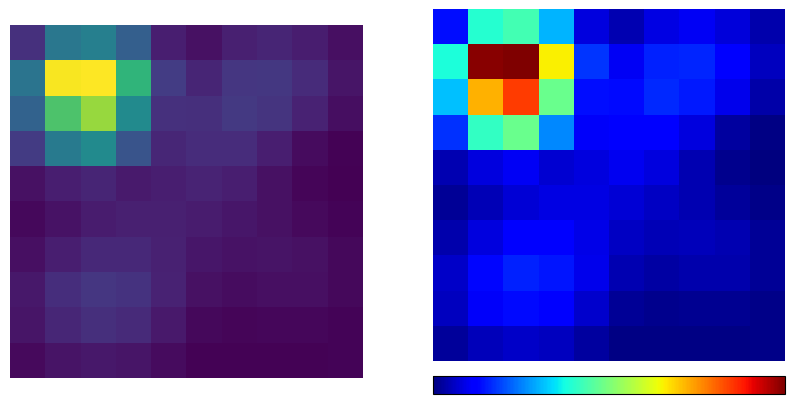

In [ ]:
# 히트맵 및 오버레이 이미지 생성
heatmap, overlay_img = show_heatmap(image_path, model)

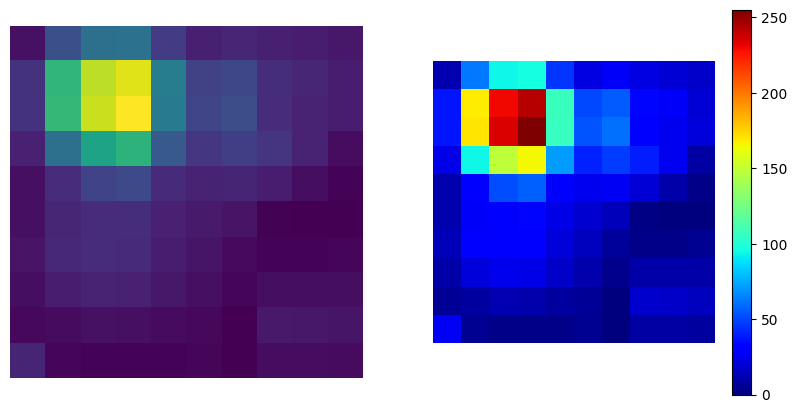

In [ ]:
# 히트맵 및 오버레이 이미지 생성
heatmap, overlay_img = show_heatmap(image_path, model)

<ipython-input-49-c4d6daa49adb>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet") #jet 컬러맵으로 표시


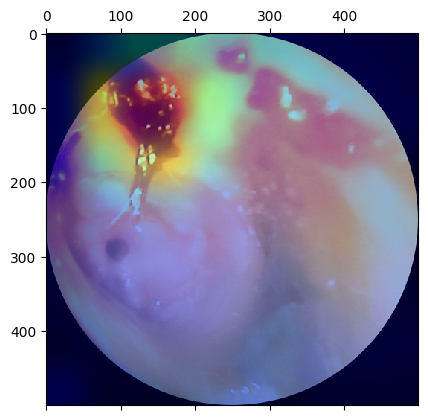

In [ ]:
img =image.load_img(image_path) #입력 영상을 다시 받음

img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]

color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img= color_heatmap*0.4+img #덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)